#安裝套件

In [ ]:
!pip install yfinance

In [ ]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.9 MB/s eta 0:00:00


#使用 LSTM 模型預測股票未來價格，自訂窗口大小，並分析預測效果。

輸出結果範例：
輸入20天收盤價，預測隔一天收盤價

##抓取股價資料

In [ ]:
import yfinance as yf # yahoo finance 套件
import pandas as pd # 結構化資料處理套件
import datetime as dt # 時間套件
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools

In [ ]:
# 設定台積電的股票代碼
stock_id = "2330.TW"  # 台積電在台灣證券交易所的代碼

start = dt.datetime(2020, 1, 1)  # 指定的開始日期
end = dt.datetime(2024, 1, 1)

# 抓取股價資料
data = yf.download(stock_id, start=start, end=end)

# 清理資料，將二維欄位名稱平展成一維
data.columns = data.columns.map(lambda x: x[0])  # 取得第二層的欄位名稱

data.reset_index(inplace=True)

data['Date'] = data['Date'].dt.date

data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)

# 顯示資料
data

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-01-02,306.430206,339.0,339.0,332.5,332.5,31754120
2020-01-03,306.882172,339.5,345.0,335.5,344.0,41811268
2020-01-06,300.102692,332.0,334.5,332.0,333.0,45343057
2020-01-07,297.842865,329.5,333.0,326.5,332.5,50879181
2020-01-08,297.842865,329.5,333.0,325.0,325.0,37567748
...,...,...,...,...,...,...
2023-12-25,573.515625,581.0,585.0,580.0,582.0,9548143
2023-12-26,578.451233,586.0,586.0,582.0,583.0,16094308
2023-12-27,584.373962,592.0,592.0,586.0,587.0,33401336


##LSTM

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 取出收盤價並正規化
data_close = data[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_close)

# 定義窗口大小
window_size = 20  # 使用過去20天的數據來預測
X_train, y_train = [], []

# 使用過去 20 天的資料來預測隔一天
train_size = len(scaled_data) - 100  # 訓練集的大小
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - window_size:]  # 包含一些訓練集末端的數據用作窗口

for i in range(window_size, len(scaled_data)):
    X_train.append(scaled_data[i-window_size:i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape數據以符合LSTM的輸入需求
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# 生成測試集 X_test 和 y_test
X_test, y_test = [], []
for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # 單個輸出：下一天的價格

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1310
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0089
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0075
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0073
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0063
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0051
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0053
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0054
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0053
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0053
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0051
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0047
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0048
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0051
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0041
Epoch 16/50
30/

In [ ]:
# 對測試集進行預測
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)  # 還原預測價格
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # 還原實際價格


print("預測隔一天的收盤價：", predicted_prices[0][0])


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
預測隔一天的收盤價： 553.9901


均方根誤差 (RMSE): 10.632825938222608


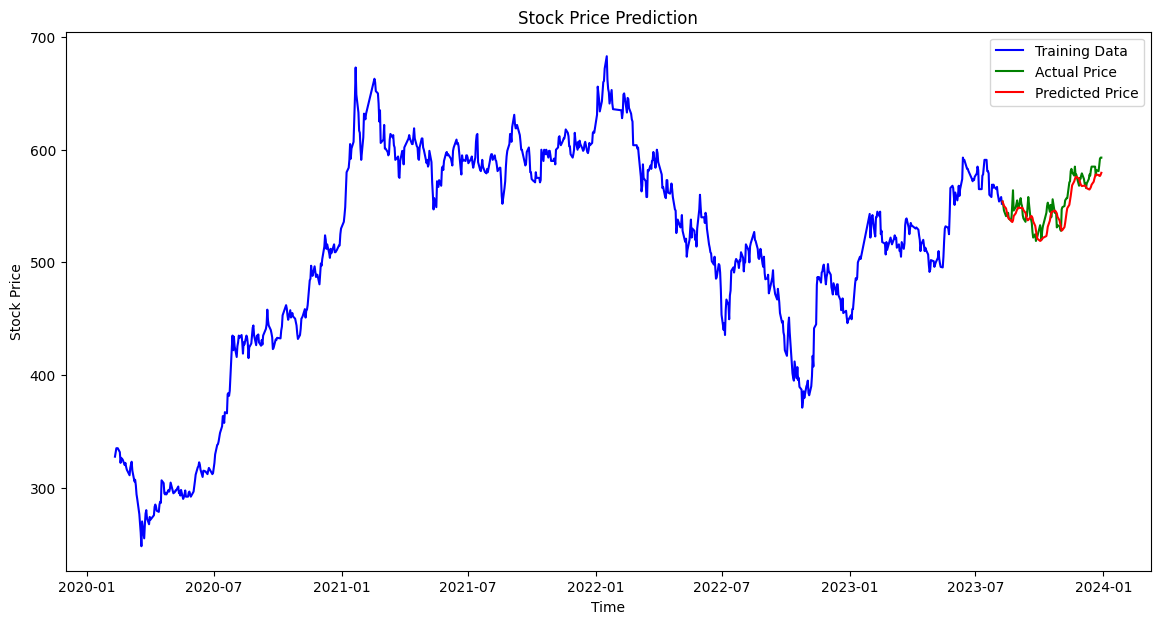

In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

rmse = np.sqrt(mean_squared_error(y_test, predicted_prices))
print("均方根誤差 (RMSE):", rmse)

# 繪圖
# 可視化
train_plot = scaler.inverse_transform(train_data[window_size:])
plt.figure(figsize=(14, 7))

# 畫出訓練資料的實際價格
plt.plot(data_close.index[window_size:train_size], train_plot, color="blue", label="Training Data")

# 畫出測試資料的實際價格
plt.plot(data_close.index[train_size:], y_test, color="green", label="Actual Price")

# 畫出測試資料的預測價格
plt.plot(data_close.index[train_size:], predicted_prices, color="red", label="Predicted Price")

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


#使用 Transformer 模型預測股價漲跌，自訂窗口大小，並分析預測結果。

輸出結果範例：
輸入20天收盤價，預測隔一天收盤價

##抓取股價資料

In [98]:
import yfinance as yf # yahoo finance 套件
import pandas as pd # 結構化資料處理套件
import datetime as dt # 時間套件
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools

In [99]:
# 設定台積電的股票代碼
stock_id = "2330.TW"  # 台積電在台灣證券交易所的代碼

start = dt.datetime(2020, 1, 1)  # 指定的開始日期
end = dt.datetime(2024, 1, 1)

# 抓取股價資料
data = yf.download(stock_id, start=start, end=end)

# 清理資料，將二維欄位名稱平展成一維
data.columns = data.columns.map(lambda x: x[0])  # 取得第二層的欄位名稱

data.reset_index(inplace=True)

data['Date'] = data['Date'].dt.date

data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)

# 顯示資料
data

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-01-02,306.430206,339.0,339.0,332.5,332.5,31754120
2020-01-03,306.882172,339.5,345.0,335.5,344.0,41811268
2020-01-06,300.102692,332.0,334.5,332.0,333.0,45343057
2020-01-07,297.842865,329.5,333.0,326.5,332.5,50879181
2020-01-08,297.842865,329.5,333.0,325.0,325.0,37567748
...,...,...,...,...,...,...
2023-12-25,573.515625,581.0,585.0,580.0,582.0,9548143
2023-12-26,578.451233,586.0,586.0,582.0,583.0,16094308
2023-12-27,584.373962,592.0,592.0,586.0,587.0,33401336


##Transformer

In [107]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [108]:
data_close = data[['Close']]

train_size = len(data_close) - 100

train_data = data_close[:train_size]
test_data = data_close[train_size:]

print(train_data.shape)
print(test_data.shape)

(873, 1)
(100, 1)


In [109]:
# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled_data = scaler.fit_transform(train_data)
test_scaled_data = scaler.transform(test_data)

window_size = 20

X_train, y_train = [], []
for i in range(len(train_scaled_data) - window_size):
    X_train.append(train_scaled_data[i:i + window_size, 0])
    y_train.append(train_scaled_data[i + window_size, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test, y_test = [], []
for i in range(len(test_scaled_data) - window_size):
    X_test.append(test_scaled_data[i:i+window_size])
    y_test.append(test_scaled_data[i+window_size])

X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(853, 20, 1)
(853,)
(80, 20, 1)
(80, 1)


In [115]:
import tensorflow as tf
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):

    x = layers.LayerNormalization(epsilon=epsilon)(inputs)

    x = layers.MultiHeadAttention(
        key_dim=head_size,
        num_heads=num_heads,
        dropout=dropout,
        attention_axes=attention_axes
    )(x, x)
    x = layers.Dropout(dropout)(x)

    res = x + inputs


    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):


    window_size, n_outputs, n_features = 20, 1, 1

    inputs = tf.keras.Input(shape=(window_size, n_features), name='Input')
    x = inputs


    for _ in range(num_trans_blocks):
        x = transformer_encoder(
            x,
            head_size=head_size,
            num_heads=num_heads,
            ff_dim=ff_dim,
            dropout=dropout,
            attention_axes=attention_axes,
            kernel_size=kernel_size,
            epsilon=epsilon
        )


    x = layers.GlobalAveragePooling1D(data_format='channels_first')(x)

    for dim in mlp_units:
        x = layers.Dense(dim, activation='relu')(x)
        x = layers.Dropout(mlp_dropout)(x)


    outputs = layers.Dense(n_outputs)(x)
    return tf.keras.Model(inputs, outputs, name='one-step_prediction_transformer_encoder_model')

In [111]:
transformer_model = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
transformer_model.compile(optimizer='adam', loss='mse')
transformer_model.summary()

Model: "one-step_prediction_transformer_encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)        │ (None, 20, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_52    │ (None, 20, 1)          │              2 │ Input[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_26   │ (None, 20, 1)          │          3,585 │ layer_normalization_5… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_96 (Dropout)      │ (None, 20, 1)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_24 (Add)              │ (None, 20, 1)          │              0 │ dropout_96[0][0],      │
│                           │                        │                │ Input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_53    │ (None, 20, 1)          │              2 │ add_24[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_24 (Conv1D)        │ (None, 20, 2)          │              4 │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_97 (Dropout)      │ (None, 20, 2)          │              0 │ conv1d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_25 (Conv1D)        │ (None, 20, 1)          │              3 │ dropout_97[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_25 (Add)              │ (None, 20, 1)          │              0 │ conv1d_25[0][0],       │
│                           │                        │                │ add_24[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_54    │ (None, 20, 1)          │              2 │ add_25[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_27   │ (None, 20, 1)          │          3,585 │ layer_normalization_5… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_99 (Dropout)      │ (None, 20, 1)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_26 (Add)              │ (None, 20, 1)          │              0 │ dropout_99[0][0],      │
│                           │                        │                │ add_25[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_55    │ (None, 20, 1)          │              2 │ add_26[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 20,017 (78.19 KB)

 Trainable params: 20,017 (78.19 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
# 訓練模型
transformer_model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - loss: 0.0211 - val_loss: 0.0034
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0094 - val_loss: 0.0022
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0068 - val_loss: 0.0018
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0056 - val_loss: 0.0013
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0049 - val_loss: 0.0014
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0042 - val_loss: 9.6884e-04
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0047 - val_loss: 8.2288e-04
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 9/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0038 - val_loss: 8.0243e-04
Epoch 10/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0029 - val_loss: 8.5030e-04
Epoch 11/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0033 - val_loss: 9.9169e-04
Epoch 12/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 

In [113]:
y_pred = transformer_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
test_predict = pd.DataFrame(y_pred, columns=['Predicted'], index=test_data[window_size:].index)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step


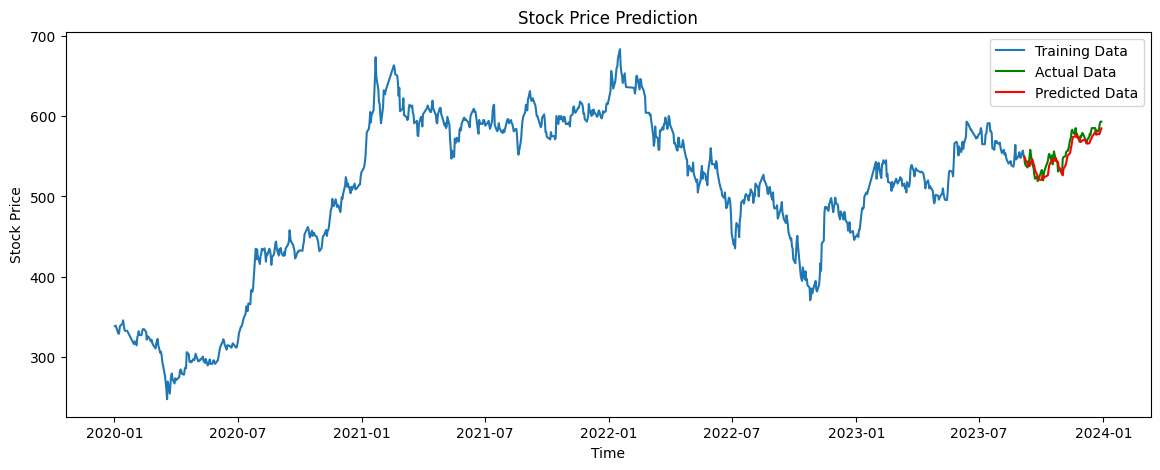

In [114]:
plt.figure(figsize=(14, 5))
plt.plot(data_close[:train_size + window_size], label='Training Data')
plt.plot(data_close[train_size + window_size:], label='Actual Data', color='green')
plt.plot(test_predict, label='Predicted Data', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()